In [1]:
import pandas as pd
import numpy as np

import csv

from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter
from lifelines import CoxPHFitter
from lifelines import WeibullFitter

from lifelines.utils import median_survival_times
from lifelines.utils import find_best_parametric_model

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from empiricaldist import Pmf  

from scipy.stats import probplot

from datetime import datetime, timezone

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')

In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

In [4]:
csv.field_size_limit(100000000)

131072

In [5]:
original_data = pd.read_csv('cve_epss_cvss.csv', encoding = 'utf-8-sig', engine = 'python')
original_data['publishedDate'] = pd.to_datetime(original_data['publishedDate'], errors='coerce')

In [6]:
# Get the current date and time in UTC
current_utc_time = pd.Timestamp.now(tz='UTC')

# Calculate the time difference
original_data['days_difference'] = (current_utc_time - original_data['publishedDate']).dt.total_seconds() / (60 * 60 * 24)

# Convert to integer if you want the result as a whole number of days
original_data['days_difference'] = original_data['days_difference'].astype(int)

In [7]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229453 entries, 0 to 229452
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   publishedDate               229453 non-null  datetime64[ns, UTC]
 1   lastModifiedDate            229453 non-null  object             
 2   cveID                       229453 non-null  object             
 3   assigner                    229453 non-null  object             
 4   configurations.nodes        229453 non-null  object             
 5   version                     141850 non-null  float64            
 6   vectorString                141850 non-null  object             
 7   attackVector                141850 non-null  object             
 8   attackComplexity            141850 non-null  object             
 9   privilegesRequired          141850 non-null  object             
 10  userInteraction             141850 non-null 

In [8]:
# Map numerical values to criticality levels and add a 'Criticality' column to the DataFrame.

def map_criticality(df):
    # Define the mapping function
    def map_to_criticality(value):
        if 0 <= value < 4:
            return 'Low'
        elif 4 <= value < 7:
            return 'Medium'
        elif 7 <= value < 9:
            return 'High'
        elif 9 <= value <= 10:
            return 'Critical'
        else:
            return 'Low'

    # Apply the mapping function to create the 'Criticality' column
    df['Criticality'] = df['cvssScore'].apply(map_to_criticality)

    return df

In [9]:
original_data = map_criticality(original_data)

In [10]:
# Ratio of criticality scores in the synthetic dataset (e.g., [0.4, 0.3, 0.2, 0.1]).
CRITICALITY_RATIO = [0.15, 0.7, 0.1, 0.05]
# Number of samples to generate in the synthetic dataset.
NUM_SAMPLES = 10000

In [11]:
# Generate a synthetic dataset with time-to-remediate based on the criticality score.
def generate_synthetic_data(original_data, num_samples, criticality_ratio):
    # Check if the 'Criticality' and 'Exploitability' columns are present in the original data
    required_columns = {'Criticality', 'epss', 'cvssScore', 'publishedDate'}
    if not required_columns.issubset(original_data.columns):
        raise KeyError(f"The columns {required_columns} are not present in the original_data DataFrame.")

    # Check if the criticality_ratio is valid
    if len(criticality_ratio) != len(original_data['Criticality'].unique()):
        raise ValueError("The length of criticality_ratio should match the number of unique criticality scores.")

    # Initialize an empty DataFrame for the synthetic data
    synthetic_data = pd.DataFrame(columns=['Time_to_Remediate', 'Criticality', 'CVSS_Score', 'Exploitability', 'Remediated'])

    # Generate synthetic data based on the given ratio
    for ratio, crit_level in zip(criticality_ratio, original_data['Criticality'].unique()):
        # Check if there are vulnerabilities for the current criticality level
        if crit_level not in original_data['Criticality'].values:
            continue

        # Calculate the number of samples for the current criticality level
        num_samples_crit_level = int(num_samples * ratio)

        # Randomly select vulnerabilities for the current criticality level
        subset_data = original_data[original_data['Criticality'] == crit_level]

        # Check if there are vulnerabilities for the current criticality level
        if subset_data.empty:
            continue

        sampled_indices = np.random.choice(subset_data.index, size=num_samples_crit_level, replace=True)

        # Extract CVSS scores for selected vulnerabilities
        cvss_score = subset_data.loc[sampled_indices, 'cvssScore'].values

        # Extract exploitability scores for selected vulnerabilities
        exploitability = subset_data.loc[sampled_indices, 'epss'].values
        
        # Extract age for selected vulnerabilities
        days_difference = subset_data.loc[sampled_indices, 'days_difference'].values


        # Create a DataFrame with the generated data
        synthetic_subset = pd.DataFrame({
            'Time_to_Remediate': days_difference,
            'Criticality': [crit_level] * num_samples_crit_level,
            'CVSS_Score': cvss_score,
            'Exploitability': exploitability,
            'Remediated': np.random.choice([0, 1], size=num_samples_crit_level)  # Random choice of 0 or 1 for 'Remediated'
        })

        # Append the synthetic subset to the overall synthetic data
        synthetic_data = synthetic_data.append(synthetic_subset)

    # Reset the index of the synthetic data
    synthetic_data.reset_index(drop=True, inplace=True)

    return synthetic_data


In [12]:
# Generate synthetic data with NUM_SAMPLES vulnerabilities
synthetic_data = generate_synthetic_data(original_data, NUM_SAMPLES, CRITICALITY_RATIO)

In [13]:
# Function to plot the distribution of criticality values
def plot_criticality_distribution(data):
    criticality_counts = data['Criticality'].value_counts()
    
    # Plot a bar chart
    criticality_counts.plot(kind='bar', color=['darkred', 'grey', 'lightblue', 'darkgrey'])
    
    # Add labels and title
    plt.title("Distribution of Vulnerabilities by Criticality")
    plt.xlabel("Criticality Level")
    plt.ylabel("Number of Vulnerabilities")
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    
    # Display the plot
    plt.show()

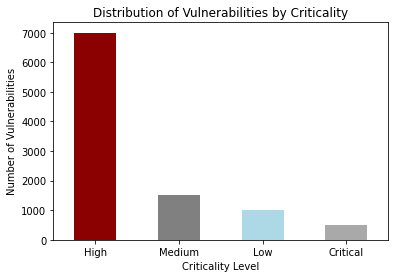

In [14]:
# Plot the distribution of criticality values
plot_criticality_distribution(synthetic_data)

In [17]:
# Function to plot the distribution of exploitability values
def plot_exploitability_distribution(data):
    # Plot a histogram of exploitability values
    plt.hist(data['Exploitability'], bins=20, color='darkred')
    
    # Add labels and title
    plt.title("Distribution of Initial Exploitability Values")
    plt.xlabel("Exploitability")
    plt.ylabel("Number of Vulnerabilities")
    
    # Display the plot
    plt.show()

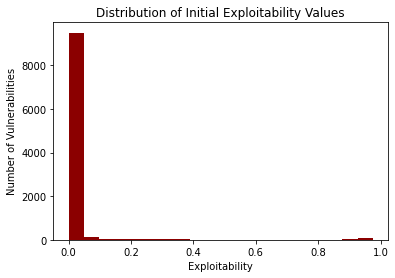

In [18]:
# Plot the distribution of exploitability values
plot_exploitability_distribution(synthetic_data)

In [19]:
# Function to plot the distribution of exploitability values
def plot_age_distribution(data):
    # Plot a histogram of exploitability values
    plt.hist(data['Time_to_Remediate'], bins=20, color='darkred')
    
    # Add labels and title
    plt.title("Distribution of Vulnerability Age")
    plt.xlabel("Age")
    plt.ylabel("Number of Vulnerabilities")
    
    # Display the plot
    plt.show()

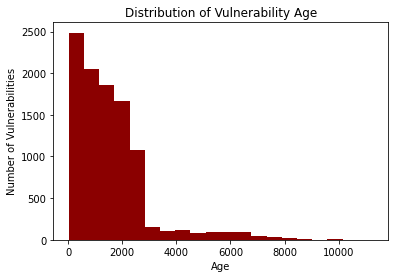

In [20]:
# Plot the distribution of exploitability values
plot_age_distribution(synthetic_data)

***
### Overall Survival
***

In [21]:
# Function to calculate overall hazard using the Kaplan-Meier estimator
def calculate_overall_hazard(data):
    # Identify events (1) and censored observations (0)
    event_observed = np.where(data['Remediated'] == 1, 1, 0)
    kmf = KaplanMeierFitter()
    kmf.fit(durations=data['Time_to_Remediate'], event_observed=event_observed)
    
    # Calculate the negative logarithm of the survival function (proportional to hazard function)
    overall_hazard = -np.log(kmf.survival_function_)
    
    return overall_hazard

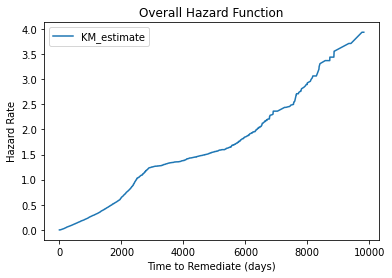

In [22]:
# Calculate and plot the overall hazard function
overall_hazard = calculate_overall_hazard(synthetic_data)
overall_hazard.plot(label="Overall")
plt.title("Overall Hazard Function")
plt.xlabel("Time to Remediate (days)")
plt.ylabel("Hazard Rate")
plt.legend()
plt.show()

***
### Survival by Criticality Level
***

In [23]:
# Function to perform survival analysis and plot survival and hazard functions
def perform_survival_analysis(data, criticality_level):
    kmf = KaplanMeierFitter()

    # Filter data for the specified criticality level
    subset_data = data[data['Criticality'] == criticality_level]

    # Identify events (1) and censored observations (0)
    event_observed = np.where(subset_data['Remediated'] == 1, 1, 0)

    # Fit the Kaplan-Meier estimator
    kmf.fit(durations=subset_data['Time_to_Remediate'], event_observed=event_observed)

    # Check if there is variation in survival probabilities
    if len(np.unique(kmf.survival_function_.values)) > 1:
        # Plot the survival curve
        kmf.plot_survival_function()

        # Add labels and title
        plt.title(f"Survival Analysis for {criticality_level} Criticality")
        plt.xlabel("Time to Remediate (days)")
        plt.ylabel("Survival Probability")

        # Display the survival plot
        plt.show()

        kmf.plot_cumulative_density()
        # Add labels and title
        plt.title(f"Cumulative Survival Curve for {criticality_level} Criticality")
        plt.xlabel("Time to Remediate (days)")
        plt.ylabel("Hazard Function (proportional)")
        

        # Display the hazard plot
        plt.show()
    else:
        print(f"No variation in survival probabilities for {criticality_level} Criticality. Hazard plot not generated.")
    return kmf

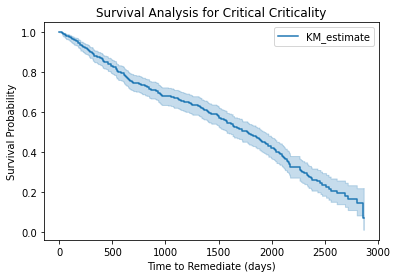

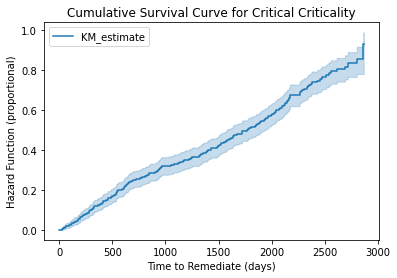

1773.0
The median survival duration (min) of Critical vulnerabilities:       KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                  1576.0                  1939.0


,KM_estimate
timeline,
2821.0,0.142762
2845.0,0.142762
2847.0,0.142762
2864.0,0.071381
2866.0,0.071381


In [24]:
kmf = perform_survival_analysis(synthetic_data, 'Critical')
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print("The median survival duration (min) of Critical vulnerabilities: ", median_confidence_interval_)
kmf.survival_function_.tail()

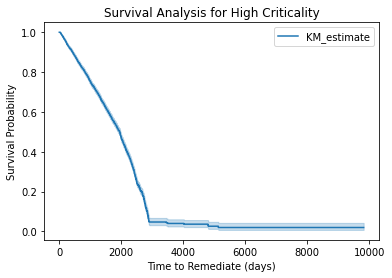

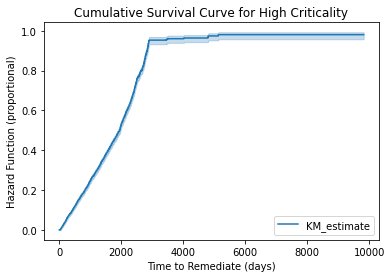

1952.0
The median survival duration (min) of High vulnerabilities:       KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                  1896.0                  1969.0


,KM_estimate
timeline,
4564.0,0.036043
4798.0,0.030894
4808.0,0.025745
5132.0,0.019309
9823.0,0.019309


In [25]:
kmf = perform_survival_analysis(synthetic_data, 'High')
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print("The median survival duration (min) of High vulnerabilities: ", median_confidence_interval_)
kmf.survival_function_.tail()

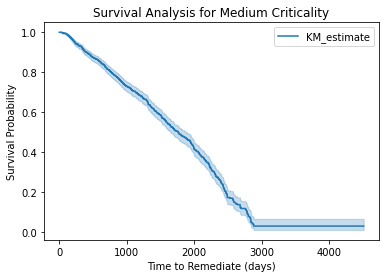

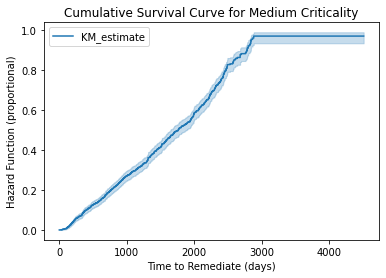

1764.0
The median survival duration (min) of Medium vulnerabilities:       KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                  1651.0                  1885.0


,KM_estimate
timeline,
2870.0,0.040004
2882.0,0.030003
2886.0,0.030003
3286.0,0.030003
4512.0,0.030003


In [26]:
kmf = perform_survival_analysis(synthetic_data, 'Medium')
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print("The median survival duration (min) of Medium vulnerabilities: ", median_confidence_interval_)
kmf.survival_function_.tail()

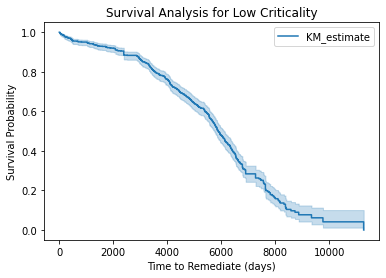

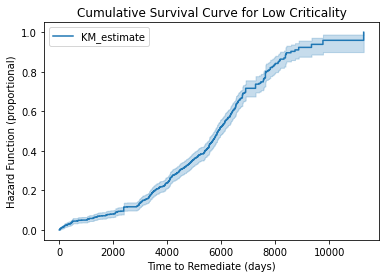

5886.0
The median survival duration (min) of Low vulnerabilities:       KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                  5748.0                  6100.0


,KM_estimate
timeline,
8871.0,0.076591
9340.0,0.061273
9408.0,0.061273
9764.0,0.040849
11272.0,0.000000


In [27]:
kmf = perform_survival_analysis(synthetic_data, 'Low')
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print("The median survival duration (min) of Low vulnerabilities: ", median_confidence_interval_)
kmf.survival_function_.tail()

***
### Weibull Fitter
***
Weibull distribution: the failure/event rate is proportional to time.

In [28]:
def perform_weibull_analysis(data):

    # Add a small positive value to zero elements in 'Time_to_Remediate'
    data['Time_to_Remediate'] = np.maximum(data['Time_to_Remediate'], 1e-6)

    wb = WeibullFitter()

    # Fit the Weibull model
    wb.fit(data['Time_to_Remediate'], data['Remediated'])

    # Print the summary
    wb.print_summary()

    # Plot survival function
    wb.survival_function_.plot()
    # Hide the legend
    plt.legend().set_visible(False)
    plt.show()
    return wb

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 10000 total observations, 5028 right-censored observations>
   number of observations = 10000
number of events observed = 4972
           log-likelihood = -44865.28
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 2971.82      36.49          2900.31          3043.33
rho_       1.18       0.01             1.15             1.20

          cmp to     z      p   -log2(p)
lambda_     1.00 81.42 <0.005        inf
rho_        1.00 13.98 <0.005     145.05
---
AIC = 89734.56

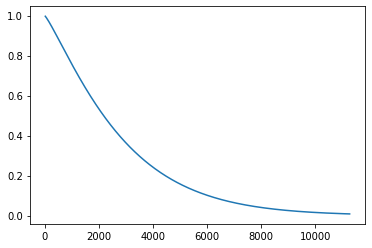

In [29]:
wb = perform_weibull_analysis(synthetic_data)

In the context of a Weibull survival analysis, the shape parameter k or ρ is a crucial component that influences the hazard function, and determines the shape.

In our case k = 1.18 or k>1 or ρ>1 implies a increasing hazard rate, which in this context can be translated as the patching process experiencing a increasing "risk of failure" or remediation over time.

In [30]:
# Predicting likelihood of survival
wb.predict(180)

0.9638615564876977

In [31]:
# Perform Weibull AFT analysis and plot partial effects.

def perform_weibull_aft_analysis(data):
    # Encode categorical variables to numerical values
    label_encoder = LabelEncoder()
    data['Criticality'] = label_encoder.fit_transform(data['Criticality'])

    # Add a small positive value to zero elements in 'Time_to_Remediate'
    data['Time_to_Remediate'] = np.maximum(data['Time_to_Remediate'], 1e-6)

    aft = WeibullAFTFitter()

    # Fit the Weibull AFT model
    aft.fit(data, duration_col='Time_to_Remediate', event_col='Remediated', show_progress=True)

    # Print the summary
    aft.print_summary()

    # Plot the partial effects for 'Criticality'
    aft.plot_partial_effects_on_outcome(covariates='Criticality', values=np.unique(data['Criticality']), cmap='coolwarm')
    plt.title("Effect of Criticality on Survival Time")
    plt.show()

    # Plot the partial effects for 'Exploitability'
    aft.plot_partial_effects_on_outcome(covariates='Exploitability', values=np.unique(data['Exploitability']), cmap='coolwarm')
    plt.title("Effect of Exploitability on Survival Time")
    # Hide the legend
    plt.legend().set_visible(False)
    plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.400914986471797
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
     fun: 4.400914986471797
     jac: array([-3.59183680e-06,  1.17961988e-06, -1.13538519e-06, -1.31203303e-07,
       -2.22712776e-07])
 message: 'Optimization terminated successfully'
    nfev: 15
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([-0.40705921, -0.15920259,  0.07701736,  9.18811574,  0.39892631])


<lifelines.WeibullAFTFitter: fitted with 10000 total observations, 5028 right-censored observations>
             duration col = 'Time_to_Remediate'
                event col = 'Remediated'
   number of observations = 10000
number of events observed = 4972
           log-likelihood = -44009.15
         time fit was run = 2023-11-24 07:38:49 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                              
lambda_ CVSS_Score      -0.16       0.85       0.00            -0.17            -0.15                 0.84                 0.86
        Criticality     -0.20       0.82       0.02            -0.23            -0.17                 0.79                 0.84
        Exploitability   0.63       1.87       0.09             0.44             0.81                 1.56                 2.24
        Intercept        9.19    9780.21       0.05             9.10             9.28              8924.94             10717.43
rho_    Intercept        0.40       1.49       0.01             0.38             0.42                 1.46                 1.52

                         cmp to      z      p   -log2(p)
param   covariate                                       
lambda_ CVSS_Score         0.00 -36.77 <0.005     980.96
        Criticality        0.00 -13.37 <0.005     132.97
        Exploitability     0.00   6.76 <0.005      36.07
        Intercept          0.00 196.79 <0.005        inf
rho_    Intercept          0.00  34.05 <0.005     841.94
---
Concordance = 0.59
AIC = 88028.30
log-likelihood ratio test = 1712.26 on 3 df
-log2(p) of ll-ratio test = inf

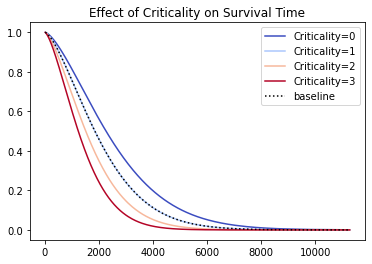

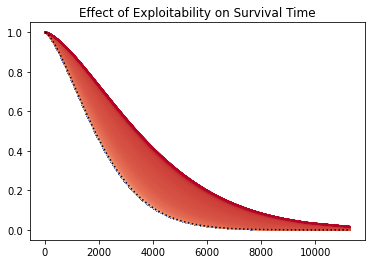

In [32]:
# Perform Weibull AFT analysis
perform_weibull_aft_analysis(synthetic_data)

Let's interpret the key components:

1. CVSS Score:
    - Coef: -0.16
    - Exp(Coef): 0.85
    - Interpretation: A one-unit increase in the CVSS Score is associated with an 15% decrease in the hazard rate. 
2. Criticality:
    - Coef: -0.20
    - Exp(Coef): 0.82
    - Interpretation: The exponentiated value (Exp(Coef)) is 0.82, indicating that as Criticality increases, the hazard of remediation decreases, similarly to the CVSS Score, which is to be expected since it's an extrapolation of the CVSS Score. A negative coefficient suggests a decrease in the hazard.
3. Exploitability:
    - Coef: 0.63
    - Exp(Coef): 1.87
    - Interpretation: A one-unit increase in Exploitability is associated with a 87% increase in the hazard rate. 
4. Rho:
    - Coef: 0.40
    - Exp(Coef): 1.49
    - Interpretation: The coefficient for Rho (ρ) represents the shape parameter of the Weibull distribution. A negative value suggests a decreasing hazard over time, while a positive value suggests an increasing hazard. This is the correlation parameter in the model. 
5. Intercept:
    - Coef: 9.19
    - Exp(Coef): 9782.30
    - Interpretation: This is the baseline hazard, and the extremely high coefficient indicates a large baseline hazard.


**Overall Interpretation:**

- The model suggests that both Criticality and Exploitability have a significant impact on the hazard of vulnerability remediation.
- Higher Criticality is associated with a significantly lower hazard of remediation.
- Higher Exploitability is associated with a higher hazard.
- The Intercept indicates a high baseline hazard, capturing the remediation risk not explained by Criticality and Exploitability.

***
### CoxPH Fitter
***

The proportional hazards assumption: all individuals' hazards are proportional to one another.

In [33]:
# Function to perform Cox Proportional Hazard analysis and plot coefficients
def perform_cox_proportional_hazard(data):
    # Encode categorical variables to numerical values
    label_encoder = LabelEncoder()
    data['Criticality'] = label_encoder.fit_transform(data['Criticality'])

    cph = CoxPHFitter()

    # Fit the Cox Proportional Hazard model
    cph.fit(data, duration_col='Time_to_Remediate', event_col='Remediated', show_progress=True)

    # Print the summary
    cph.print_summary()

    # Plot the coefficients
    cph.plot_covariate_groups('Criticality', values=np.unique(data['Criticality']), cmap='coolwarm')

    # Display the plot
    plt.show()

    # Plot the coefficients
    cph.plot_covariate_groups('Exploitability', values=np.unique(data['Exploitability']), cmap='coolwarm')
    # Hide the legend
    plt.legend().set_visible(False)
    # Display the plot
    plt.show()
    return cph

Iteration 1: norm_delta = 5.38e-01, step_size = 0.9500, log_lik = -40847.40178, newton_decrement = 6.48e+02, seconds_since_start = 0.1
Iteration 2: norm_delta = 2.66e-01, step_size = 0.9500, log_lik = -40101.99761, newton_decrement = 9.91e+01, seconds_since_start = 0.3
Iteration 3: norm_delta = 7.37e-02, step_size = 0.9500, log_lik = -39993.64690, newton_decrement = 5.33e+00, seconds_since_start = 0.4
Iteration 4: norm_delta = 3.38e-03, step_size = 1.0000, log_lik = -39988.16576, newton_decrement = 1.07e-02, seconds_since_start = 0.5
Iteration 5: norm_delta = 6.70e-06, step_size = 1.0000, log_lik = -39988.15506, newton_decrement = 4.79e-08, seconds_since_start = 0.7
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 10000 total observations, 5028 right-censored observations>
             duration col = 'Time_to_Remediate'
                event col = 'Remediated'
      baseline estimation = breslow
   number of observations = 10000
number of events observed = 4972
   partial log-likelihood = -39988.16
         time fit was run = 2023-11-24 07:38:53 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Criticality      0.38       1.47       0.02             0.34             0.43                 1.40                 1.54
CVSS_Score       0.31       1.36       0.01             0.29             0.33                 1.34                 1.39
Exploitability  -1.00       0.37       0.14            -1.28            -0.73                 0.28                 0.48

                 cmp to     z      p   -log2(p)
covariate                                      
Criticality        0.00 16.09 <0.005     191.11
CVSS_Score         0.00 32.81 <0.005     782.05
Exploitability     0.00 -7.15 <0.005      40.10
---
Concordance = 0.59
Partial AIC = 79982.31
log-likelihood ratio test = 1718.49 on 3 df
-log2(p) of ll-ratio test = inf

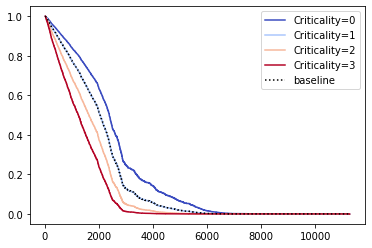

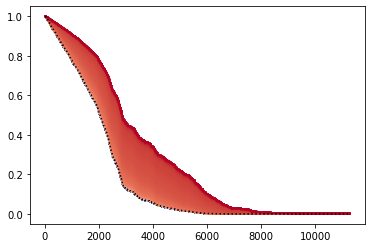

In [34]:
# Perform Cox Proportional Hazard analysis
cph = perform_cox_proportional_hazard(synthetic_data)

In [35]:
# Print model summary
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Criticality,0.382176,1.465470,0.023751,0.335625,0.428727,1.398814,1.535302,0.0,16.090856,2.957184e-58,191.107605
CVSS_Score,0.308738,1.361706,0.009409,0.290297,0.327179,1.336825,1.387050,0.0,32.813310,3.803255e-236,782.047796
Exploitability,-1.001475,0.367337,0.140009,-1.275887,-0.727063,0.279183,0.483326,0.0,-7.152952,8.493120e-13,40.098771


<Axes: xlabel='log(HR) (95% CI)'>

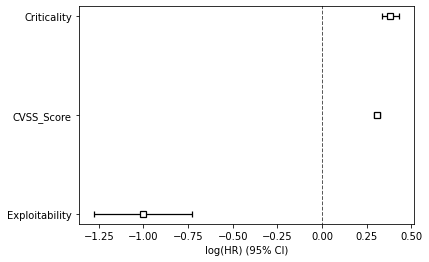

In [36]:
cph.plot()